In [1]:
import librosa
import librosa.display
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import deeplake
import random

# Load TIMIT dataset
dataset = deeplake.load('hub://activeloop/timit-train')

# Set the number of samples to randomly select
num_samples_to_use = 100

# Get the total number of files in the dataset
total_files = len(dataset)

# Generate 100 random indices for sampling
random_indices = random.sample(range(total_files), num_samples_to_use)

# Load the randomly selected WAV files
waveforms = []
for idx in random_indices:
    sample = dataset[idx]
    audio = sample['audios'].numpy().flatten()  # Flatten to get a 1D array
    waveforms.append(audio)

print(f"Loaded {len(waveforms)} randomly selected WAV files from the TIMIT dataset.")

# Create matching LR versions for each selected waveform
sr_original = 16000  # Original sample rate is 16kHz
sr_target = 8000     # Target sample rate for LR audio

waveforms_lr = []
for audio in waveforms:
    lr_audio = librosa.resample(audio, orig_sr=sr_original, target_sr=sr_target)
    waveforms_lr.append(lr_audio)

print(f"Created matching LR versions for each selected WAV file.")


C:\Users\Son.Levi\AppData\Local\anaconda3\envs\audio-super-resolution\Lib\site-packages\deeplake\util\check_latest_version.py:32: UserWarning: A newer version of deeplake (3.9.20) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(
\

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/timit-train



|

hub://activeloop/timit-train loaded successfully.



Loaded 100 randomly selected WAV files from the TIMIT dataset.
Created matching LR versions for each selected WAV file.


Global Min: -9413.0, Global Max: 11575.0
Processing Track 0: Total Length = 2.873625s, Num Chunks = 1
Chunk 0: Start = 0, End = 32000
Processing Track 1: Total Length = 3.8464375s, Num Chunks = 1
Chunk 0: Start = 0, End = 32000
Processing Track 2: Total Length = 4.24325s, Num Chunks = 2
Chunk 0: Start = 0, End = 32000
Chunk 1: Start = 32000, End = 64000
Processing Track 3: Total Length = 2.105625s, Num Chunks = 1
Chunk 0: Start = 0, End = 32000
Processing Track 4: Total Length = 3.712s, Num Chunks = 1
Chunk 0: Start = 0, End = 32000
Processing Track 5: Total Length = 2.457625s, Num Chunks = 1
Chunk 0: Start = 0, End = 32000
Processing Track 6: Total Length = 3.552s, Num Chunks = 1
Chunk 0: Start = 0, End = 32000
Processing Track 7: Total Length = 3.0528125s, Num Chunks = 1
Chunk 0: Start = 0, End = 32000
Processing Track 8: Total Length = 2.72s, Num Chunks = 1
Chunk 0: Start = 0, End = 32000
Processing Track 9: Total Length = 3.37925s, Num Chunks = 1
Chunk 0: Start = 0, End = 32000
Pro

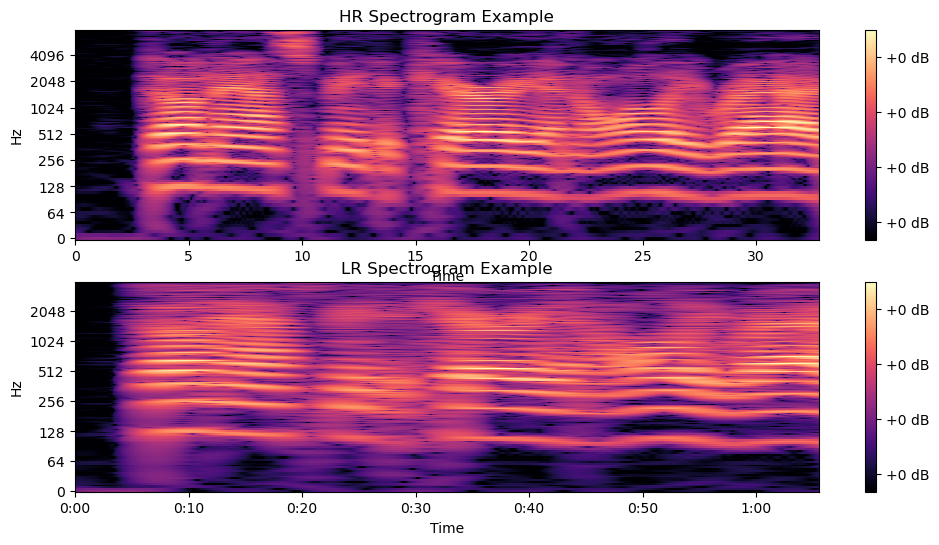

In [65]:
import librosa
import librosa.display
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate global min and max values
def calculate_global_min_max(audio_samples):
    global_min = float('inf')
    global_max = float('-inf')
    
    for audio in audio_samples:
        min_val = np.min(audio)
        max_val = np.max(audio)

        if min_val < global_min:
            global_min = min_val
        if max_val > global_max:
            global_max = max_val

    print(f"Global Min: {global_min}, Global Max: {global_max}")
    return global_min, global_max

# Function to generate a 1024x1024 spectrogram
def generate_1024x1024_spectrogram(audio, sr=16000):
    # Determine the number of time frames needed
    target_frames = 1024
    hop_length = max(1, len(audio) // target_frames)

    # Set n_fft to get close to 1024 frequency bins
    n_fft = 2048  # or another value depending on your needs

    # Compute the spectrogram
    D = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    
    # Convert to dB scale
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

    # Ensure the spectrogram is 1024x1024
    if S_db.shape[1] < 1024:
        S_db_resized = np.pad(S_db, ((0, 0), (0, 1024 - S_db.shape[1])), mode='constant')
    else:
        S_db_resized = S_db[:, :1024]

    if S_db_resized.shape[0] < 1024:
        S_db_resized = np.pad(S_db_resized, ((0, 1024 - S_db_resized.shape[0]), (0, 0)), mode='constant')
    else:
        S_db_resized = S_db_resized[:1024, :]

    return S_db_resized, np.angle(D), n_fft, hop_length

# Parameters
segment_length = 2  # 2 seconds for speech signals
sr_original = 16000  # HR sample rate
sr_low_res = 8000    # LR sample rate

# Calculate Global Min and Max Values
global_min, global_max = calculate_global_min_max(waveforms)

# Function to normalize spectrograms
def normalize_spectrogram(spectrogram, global_min, global_max):
    return (spectrogram - global_min) / (global_max - global_min)

# Modified save_spectrograms_and_phases_to_h5 function to include normalization
def save_spectrograms_and_phases_to_h5(audio_samples, output_h5_file_path, phase_output_h5_file_path, global_min=global_min, global_max=global_max):
    # Initialize lists to store spectrograms and phases
    hr_spectrograms = []
    lr_spectrograms = []

    with h5py.File(output_h5_file_path, 'w') as f, h5py.File(phase_output_h5_file_path, 'w') as phase_f:
        for i, audio in enumerate(audio_samples):
            total_length = len(audio) / sr_original
            num_chunks = int(total_length // segment_length)

            print(f"Processing Track {i}: Total Length = {total_length}s, Num Chunks = {num_chunks}")

            for chunk_idx in range(num_chunks):
                start_sample = int(chunk_idx * segment_length * sr_original)
                end_sample = int(start_sample + segment_length * sr_original)
                chunk_audio = audio[start_sample:end_sample]

                print(f"Chunk {chunk_idx}: Start = {start_sample}, End = {end_sample}")

                # Generate HR spectrogram and phase
                hr_spectrogram, hr_phase, n_fft_hr, hop_length_hr = generate_1024x1024_spectrogram(
                    chunk_audio, sr=sr_original)
                
                # Downsample and generate LR spectrogram and phase
                lr_audio = librosa.resample(chunk_audio, orig_sr=sr_original, target_sr=sr_low_res)
                lr_spectrogram, lr_phase, n_fft_lr, hop_length_lr = generate_1024x1024_spectrogram(
                    lr_audio, sr=sr_low_res)

                # Normalize the spectrograms
                hr_spectrogram_normalized = normalize_spectrogram(hr_spectrogram, global_min, global_max)
                lr_spectrogram_normalized = normalize_spectrogram(lr_spectrogram, global_min, global_max)

                # Save to HDF5
                chunk_name = f'track_{i}_chunk_{chunk_idx}'
                grp = f.create_group(chunk_name)
                grp.create_dataset('hr_spectrogram', data=hr_spectrogram_normalized, chunks=(1024, 1024), dtype='float16', compression='gzip')
                grp.create_dataset('lr_spectrogram', data=lr_spectrogram_normalized, chunks=(1024, 1024), dtype='float16', compression='gzip')

                grp.attrs['n_fft_hr'] = n_fft_hr
                grp.attrs['hop_length_hr'] = hop_length_hr
                grp.attrs['n_fft_lr'] = n_fft_lr
                grp.attrs['hop_length_lr'] = hop_length_lr

                # Append normalized spectrograms to the lists
                hr_spectrograms.append(hr_spectrogram_normalized)
                lr_spectrograms.append(lr_spectrogram_normalized)

        print(f"Number of HR spectrograms saved: {len(hr_spectrograms)}")
        print(f"Number of LR spectrograms saved: {len(lr_spectrograms)}")

    return hr_spectrograms, lr_spectrograms

# Splitting the samples into train, validation, and test sets
n_train = int(0.8 * len(waveforms))
n_val = int(0.1 * len(waveforms))
train_samples = waveforms[:n_train]
val_samples = waveforms[n_train:n_train + n_val]
test_samples = waveforms[n_train + n_val:]

# Save the train set
output_train_h5_file_path = r'C:\Users\Son.Levi\SR_Audio_Transformer\timit_sr_spectrograms_1024x1024_with_params_train_.h5'
phase_train_h5_file_path = r'C:\Users\Son.Levi\SR_Audio_Transformer\timit_sr_phases_1024x1024_train.h5'
train_hr_spectrograms, train_lr_spectrograms = save_spectrograms_and_phases_to_h5(train_samples, output_train_h5_file_path, phase_train_h5_file_path)

# Save the validation set
output_val_h5_file_path = r'C:\Users\Son.Levi\SR_Audio_Transformer\timit_sr_spectrograms_1024x1024_with_params_val_.h5'
phase_val_h5_file_path = r'C:\Users\Son.Levi\SR_Audio_Transformer\timit_sr_phases_1024x1024_val.h5'
val_hr_spectrograms, val_lr_spectrograms = save_spectrograms_and_phases_to_h5(val_samples, output_val_h5_file_path, phase_val_h5_file_path)

# Save the test set
output_test_h5_file_path = r'C:\Users\Son.Levi\SR_Audio_Transformer\timit_sr_spectrograms_1024x1024_with_params_test_.h5'
phase_test_h5_file_path = r'C:\Users\Son.Levi\SR_Audio_Transformer\timit_sr_phases_1024x1024_test.h5'
test_hr_spectrograms, test_lr_spectrograms = save_spectrograms_and_phases_to_h5(test_samples, output_test_h5_file_path, phase_test_h5_file_path)

print(f"HR and LR spectrograms have been saved to the following files:")
print(f"Train: {output_train_h5_file_path}")
print(f"Validation: {output_val_h5_file_path}")
print(f"Test: {output_test_h5_file_path}")

# Optional: Visualize one HR and LR spectrogram if available
if train_hr_spectrograms:
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.title("HR Spectrogram Example")
    librosa.display.specshow(train_hr_spectrograms[0], sr=sr_original, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')

    plt.subplot(2, 1, 2)
    plt.title("LR Spectrogram Example")
    librosa.display.specshow(train_lr_spectrograms[0], sr=sr_low_res, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')

    plt.show()


HR and LR spectrograms have been saved to the following files:
Train: C:\Users\Son.Levi\SR_Audio_Transformer\timit_sr_spectrograms_1024x1024_with_params_train_.h5
Validation: C:\Users\Son.Levi\SR_Audio_Transformer\timit_sr_spectrograms_1024x1024_with_params_val_.h5
Test: C:\Users\Son.Levi\SR_Audio_Transformer\timit_sr_spectrograms_1024x1024_with_params_test_.h5


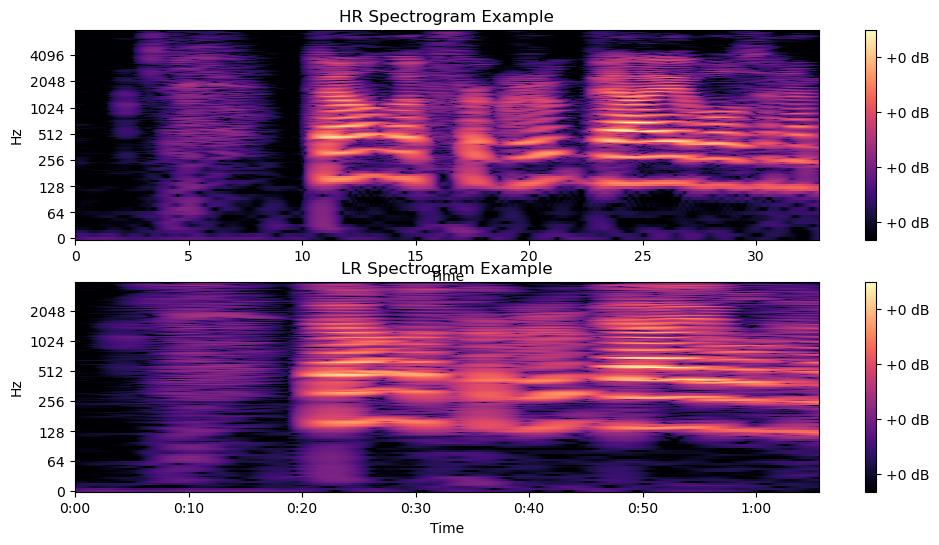

In [66]:
print(f"HR and LR spectrograms have been saved to the following files:")
print(f"Train: {output_train_h5_file_path}")
print(f"Validation: {output_val_h5_file_path}")
print(f"Test: {output_test_h5_file_path}")

# Optional: Visualize one HR and LR spectrogram if available
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.title("HR Spectrogram Example")
librosa.display.specshow(train_hr_spectrograms[9], sr=sr_original, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')

plt.subplot(2, 1, 2)
plt.title("LR Spectrogram Example")
librosa.display.specshow(train_lr_spectrograms[9], sr=sr_low_res, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')

plt.show()

In [46]:
import os
os.chdir("C:/Users/Son.Levi/Audio-Super-Resolution-ViT/ViT-SR/Autoencoder")

In [47]:
import torch
from models import GenerativeNetwork

# Initialize the model
model = GenerativeNetwork(device='cpu')

# Set the model to training mode (default is training mode, so this line is optional)
model.train()

print("Model initialized successfully. Ready for training from scratch.")


Model initialized successfully. Ready for training from scratch.


Starting Epoch 1/25...
Epoch [1/25] completed. Train Loss: 0.2590, Val Loss: 0.2491, Time: 467.59 sec


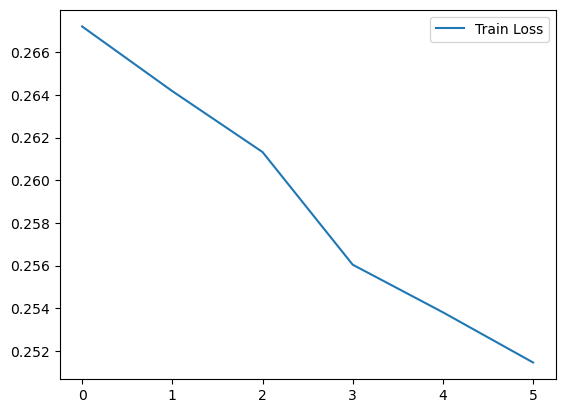

Starting Epoch 2/25...
Epoch [2/25] completed. Train Loss: 0.2432, Val Loss: 0.2350, Time: 461.48 sec


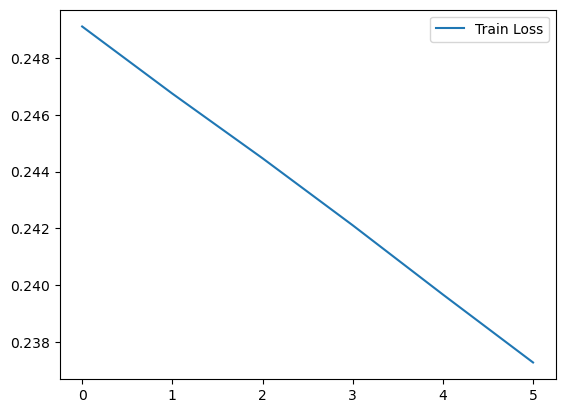

Starting Epoch 3/25...
Epoch [3/25] completed. Train Loss: 0.2290, Val Loss: 0.2203, Time: 453.31 sec


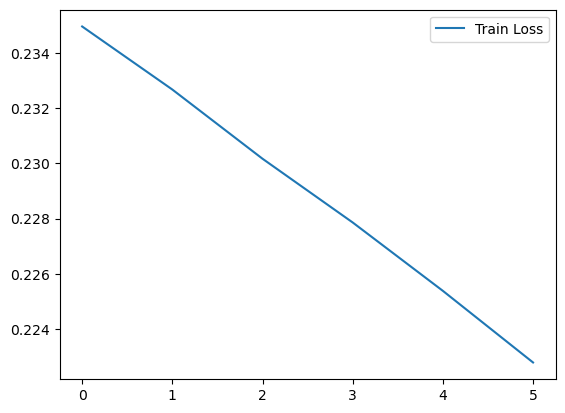

Starting Epoch 4/25...
Epoch [4/25] completed. Train Loss: 0.2142, Val Loss: 0.2055, Time: 426.75 sec


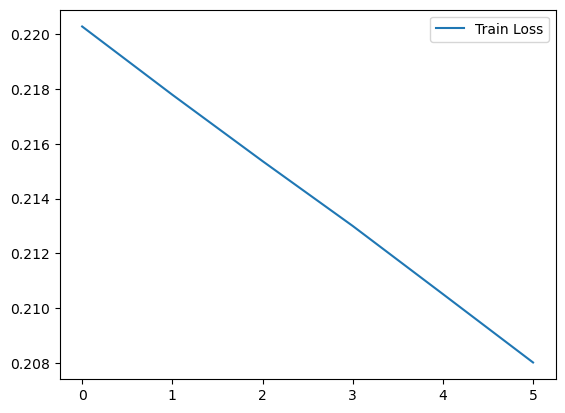

Starting Epoch 5/25...
Epoch [5/25] completed. Train Loss: 0.1988, Val Loss: 0.1892, Time: 422.85 sec


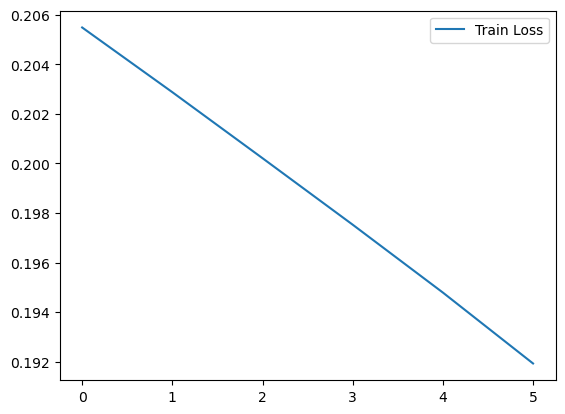

Starting Epoch 6/25...
Epoch [6/25] completed. Train Loss: 0.1818, Val Loss: 0.1712, Time: 415.19 sec


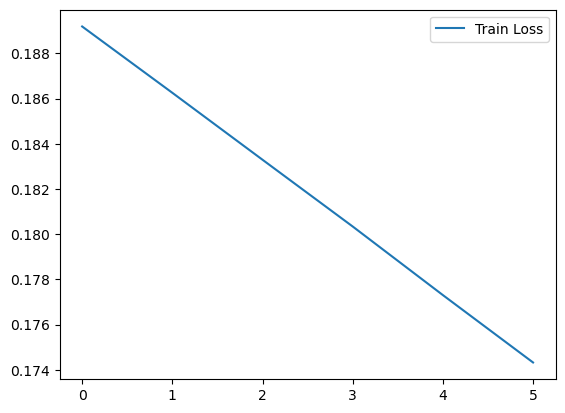

Starting Epoch 7/25...
Epoch [7/25] completed. Train Loss: 0.1632, Val Loss: 0.1511, Time: 415.84 sec


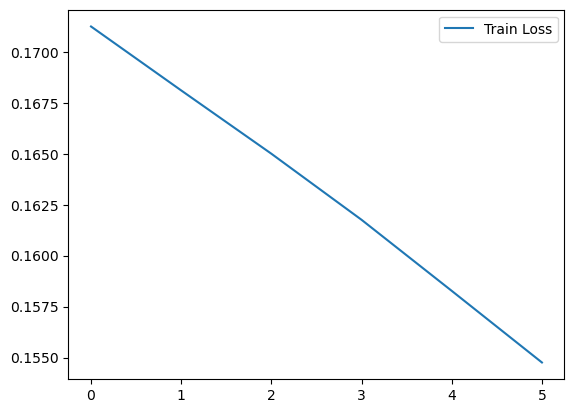

Starting Epoch 8/25...
Epoch [8/25] completed. Train Loss: 0.1417, Val Loss: 0.1275, Time: 416.49 sec


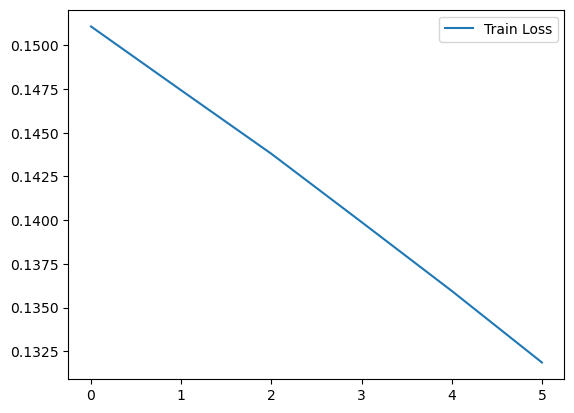

Starting Epoch 9/25...
Epoch [9/25] completed. Train Loss: 0.1154, Val Loss: 0.0983, Time: 409.46 sec


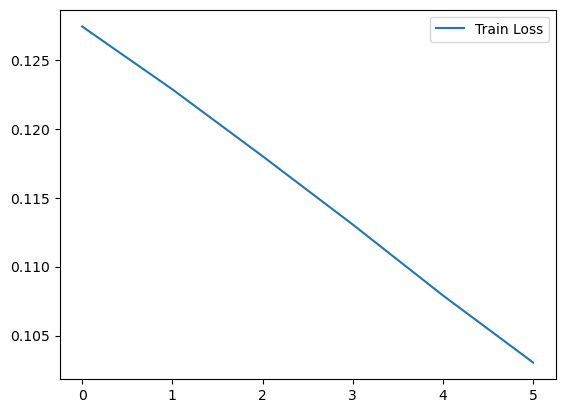

Starting Epoch 10/25...
Epoch [10/25] completed. Train Loss: 0.0862, Val Loss: 0.0696, Time: 407.23 sec
Model saved at epoch 10


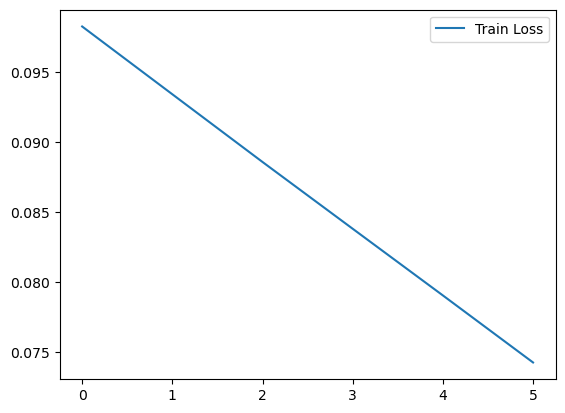

Starting Epoch 11/25...
Epoch [11/25] completed. Train Loss: 0.0587, Val Loss: 0.0445, Time: 408.46 sec


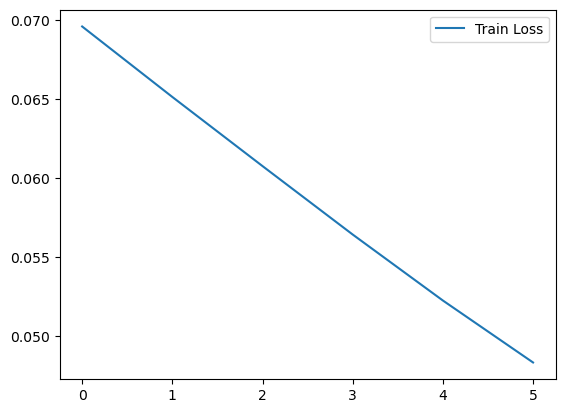

Starting Epoch 12/25...
Epoch [12/25] completed. Train Loss: 0.0359, Val Loss: 0.0249, Time: 407.71 sec


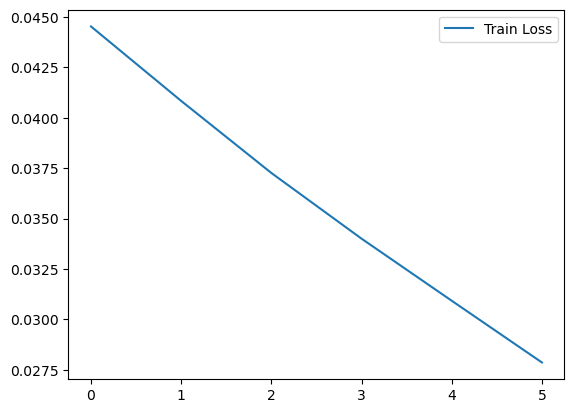

Starting Epoch 13/25...
Epoch [13/25] completed. Train Loss: 0.0184, Val Loss: 0.0131, Time: 410.52 sec


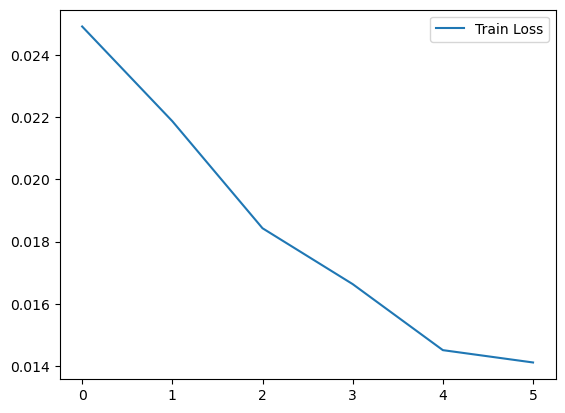

Starting Epoch 14/25...
Epoch [14/25] completed. Train Loss: 0.0120, Val Loss: 0.0103, Time: 407.18 sec


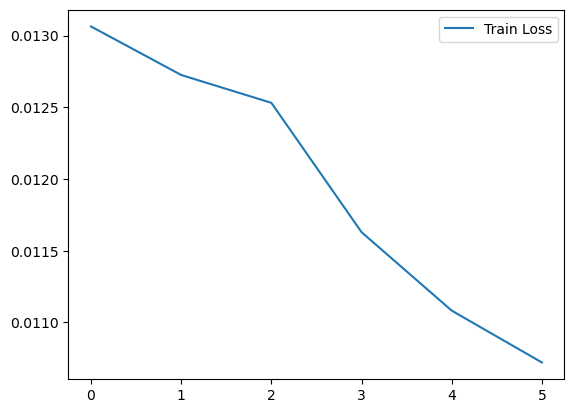

Starting Epoch 15/25...
Epoch [15/25] completed. Train Loss: 0.0090, Val Loss: 0.0074, Time: 409.46 sec


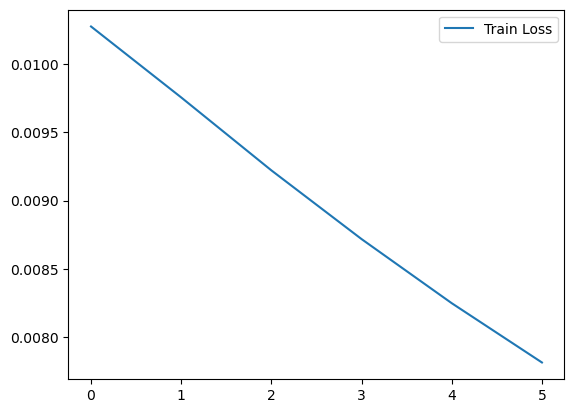

Starting Epoch 16/25...
Epoch [16/25] completed. Train Loss: 0.0068, Val Loss: 0.0061, Time: 412.81 sec


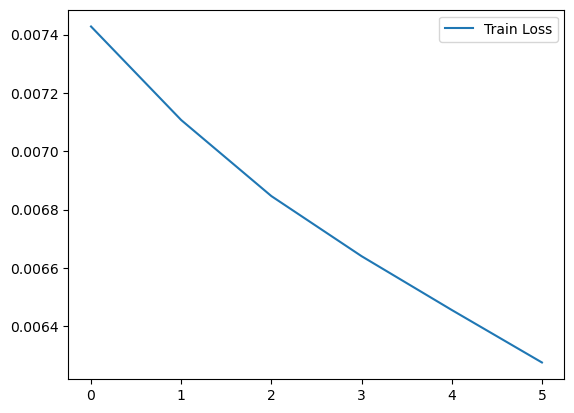

Starting Epoch 17/25...
Epoch [17/25] completed. Train Loss: 0.0055, Val Loss: 0.0047, Time: 409.84 sec


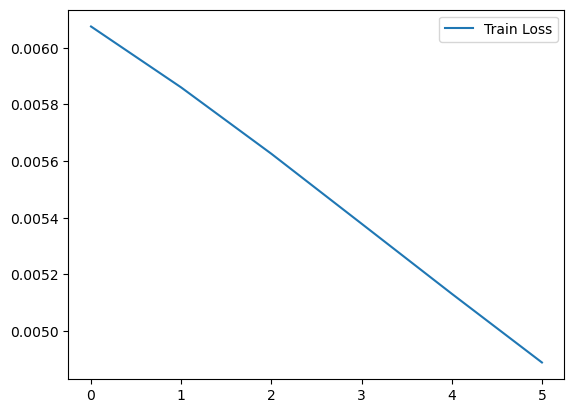

Starting Epoch 18/25...
Epoch [18/25] completed. Train Loss: 0.0042, Val Loss: 0.0037, Time: 410.01 sec


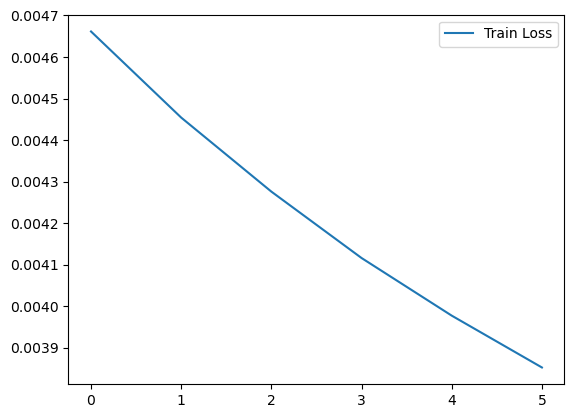

Starting Epoch 19/25...
Epoch [19/25] completed. Train Loss: 0.0035, Val Loss: 0.0031, Time: 408.89 sec


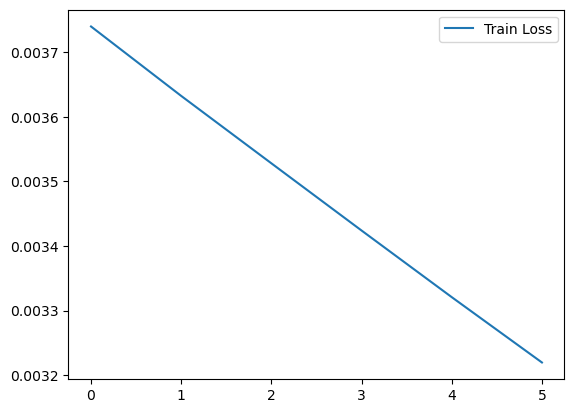

Starting Epoch 20/25...
Epoch [20/25] completed. Train Loss: 0.0029, Val Loss: 0.0027, Time: 409.64 sec
Model saved at epoch 20


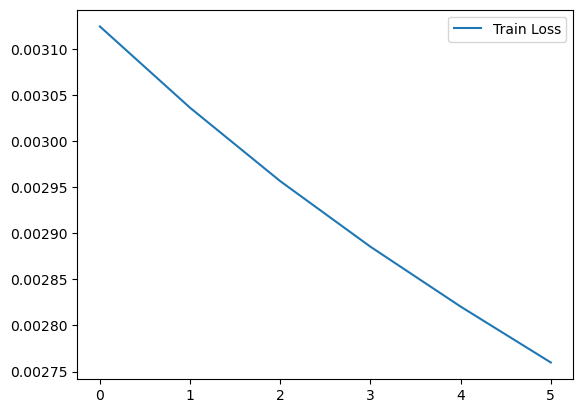

Starting Epoch 21/25...
Epoch [21/25] completed. Train Loss: 0.0026, Val Loss: 0.0024, Time: 409.94 sec


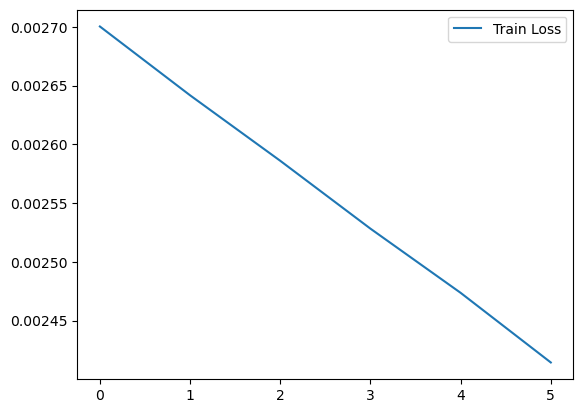

Starting Epoch 22/25...
Epoch [22/25] completed. Train Loss: 0.0022, Val Loss: 0.0020, Time: 406.95 sec


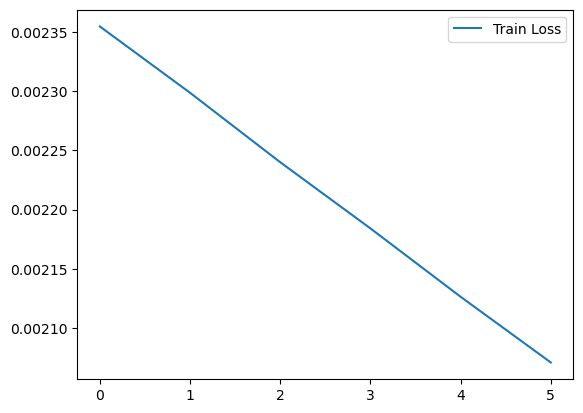

Starting Epoch 23/25...
Epoch [23/25] completed. Train Loss: 0.0019, Val Loss: 0.0017, Time: 407.90 sec


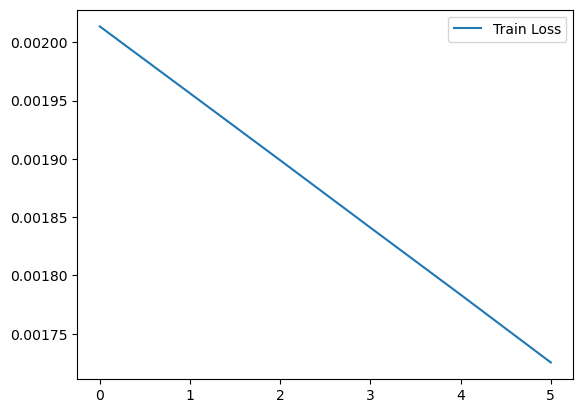

Starting Epoch 24/25...
Epoch [24/25] completed. Train Loss: 0.0015, Val Loss: 0.0013, Time: 407.22 sec


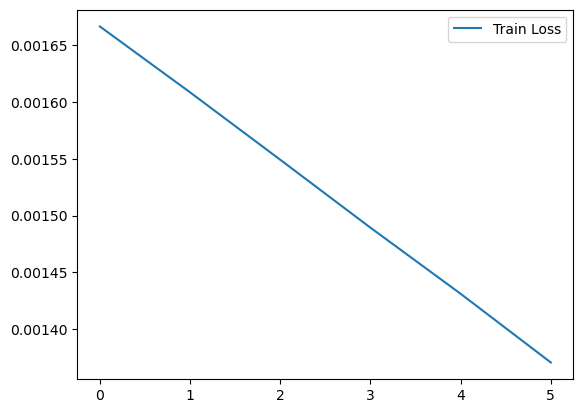

Starting Epoch 25/25...
Epoch [25/25] completed. Train Loss: 0.0012, Val Loss: 0.0010, Time: 408.59 sec


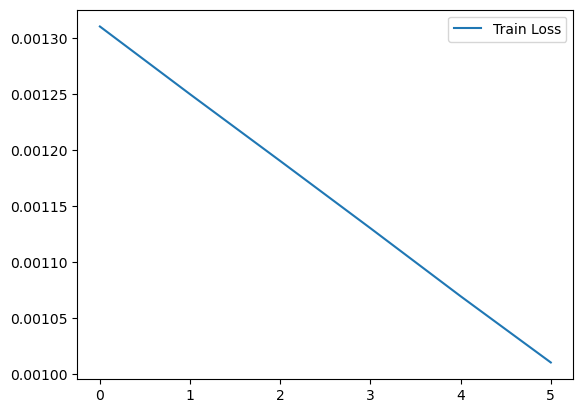

Training completed successfully.
Starting testing...
Test completed. Test Loss: 0.0010


In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import h5py
import matplotlib.pyplot as plt
from models import GenerativeNetwork  # Assuming you have this model class
import time

# Custom Dataset to Load Precomputed Spectrograms
class H5Dataset(Dataset):
    def __init__(self, h5_file_path):
        self.h5_file = h5py.File(h5_file_path, 'r')
        self.keys = list(self.h5_file.keys())

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        key = self.keys[idx]
        hr_spectrogram = self.h5_file[key]['hr_spectrogram'][:]
        lr_spectrogram = self.h5_file[key]['lr_spectrogram'][:]

        # Add a channel dimension
        hr_spectrogram = torch.tensor(hr_spectrogram, dtype=torch.float32).unsqueeze(0)
        lr_spectrogram = torch.tensor(lr_spectrogram, dtype=torch.float32).unsqueeze(0)

        return lr_spectrogram, hr_spectrogram

# Paths to your HDF5 files
train_h5_path = r'C:\Users\Son.Levi\SR_Audio_Transformer\timit_sr_spectrograms_1024x1024_with_params_train_.h5'
val_h5_path = r'C:\Users\Son.Levi\SR_Audio_Transformer\timit_sr_spectrograms_1024x1024_with_params_val_.h5'
test_h5_path = r'C:\Users\Son.Levi\SR_Audio_Transformer\timit_sr_spectrograms_1024x1024_with_params_test_.h5'

# Create DataLoader for train, validation, and test sets
train_dataset = H5Dataset(train_h5_path)
val_dataset = H5Dataset(val_h5_path)
test_dataset = H5Dataset(test_h5_path)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize the model
model = GenerativeNetwork(device='cpu')

# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer_gen = optim.Adam(model.parameters(), lr=0.001)

# Move model to device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training function
def train(generator, epochs, train_loader, val_loader):
    for epoch in range(epochs):
        print(f"Starting Epoch {epoch + 1}/{epochs}...")

        start_time = time.time()
        generator.train()
        total_loss = 0
        history = []

        for batch_lb, batch_hb in train_loader:
            batch_lb, batch_hb = batch_lb.to(device), batch_hb.to(device)

            # Forward pass
            gen_hb = generator(batch_lb)
            loss = criterion(gen_hb, batch_hb)

            # Backward pass and optimization
            optimizer_gen.zero_grad()
            loss.backward()
            optimizer_gen.step()

            total_loss += loss.item()
            history.append(loss.item())

        # Average loss
        avg_train_loss = total_loss / len(train_loader)

        # Validation
        generator.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_lb, val_hb in val_loader:
                val_lb, val_hb = val_lb.to(device), val_hb.to(device)
                gen_val_hb = generator(val_lb)
                loss = criterion(gen_val_hb, val_hb)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        # Epoch time
        end_time = time.time()
        epoch_duration = end_time - start_time

        # Print loss and time
        print(f'Epoch [{epoch + 1}/{epochs}] completed. Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Time: {epoch_duration:.2f} sec')

        # Save model periodically
        if (epoch + 1) % 10 == 0:
            torch.save(generator.state_dict(), f"generator_epoch_{epoch + 1}.pth")
            print(f"Model saved at epoch {epoch + 1}")

        # Plot the loss
        plt.plot(history, label="Train Loss")
        plt.legend()
        plt.show()

    print("Training completed successfully.")

# Testing function
def test(generator, test_loader):
    print("Starting testing...")
    generator.eval()
    test_loss = 0.0
    with torch.no_grad():
        for test_lb, test_hb in test_loader:
            test_lb, test_hb = test_lb.to(device), test_hb.to(device)
            gen_test_hb = generator(test_lb)
            loss = criterion(gen_test_hb, test_hb)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    print(f'Test completed. Test Loss: {avg_test_loss:.4f}')

# Training the model
train(model, epochs=25, train_loader=train_loader, val_loader=val_loader)

# Testing the model
test(model, test_loader)


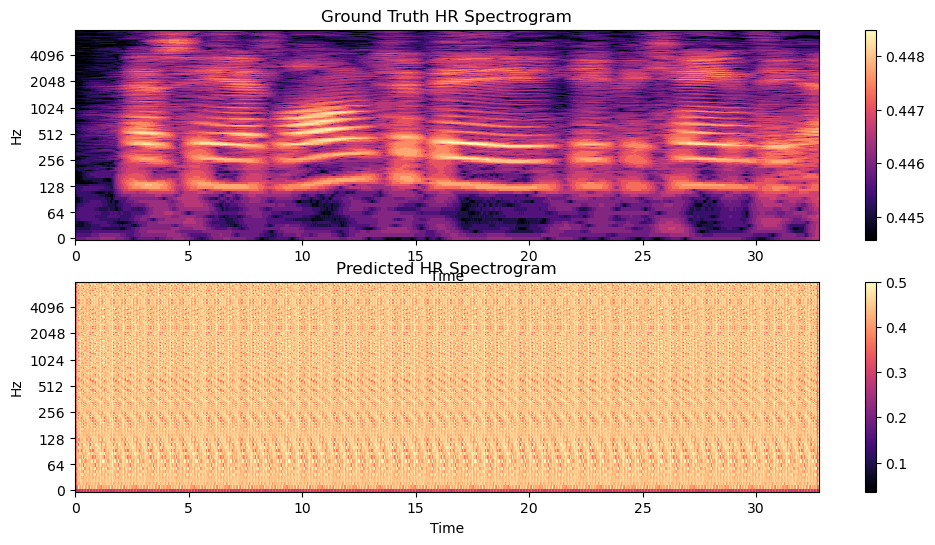

In [72]:
import matplotlib.pyplot as plt
import librosa.display

lr_spectrogram, hr_spectrogram = next(iter(test_loader))
lr_spectrogram = lr_spectrogram.to(device)

with torch.no_grad():
    predicted_hr_spectrogram = model(lr_spectrogram)

plt.figure(figsize=(12, 6))

# Plot Ground Truth HR
plt.subplot(2, 1, 1)
plt.title("Ground Truth HR Spectrogram")
librosa.display.specshow(hr_spectrogram[0].cpu().numpy().squeeze(), sr=16000, x_axis='time', y_axis='log')
plt.colorbar()

# Plot Predicted HR
plt.subplot(2, 1, 2)
plt.title("Predicted HR Spectrogram")
librosa.display.specshow(predicted_hr_spectrogram[0].cpu().numpy().squeeze(), sr=16000, x_axis='time', y_axis='log')
plt.colorbar()

plt.show()


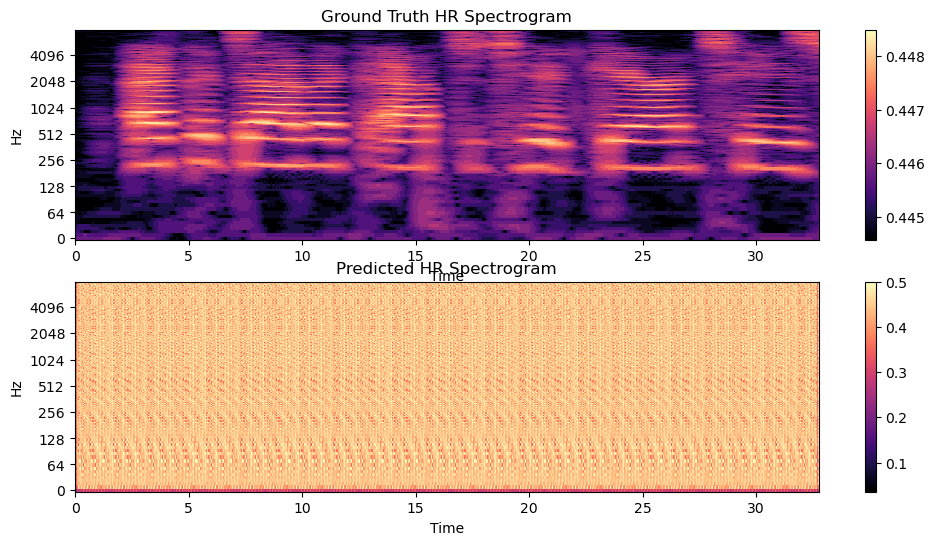

In [73]:
import matplotlib.pyplot as plt
import librosa.display

lr_spectrogram, hr_spectrogram = next(iter(test_loader))
lr_spectrogram = lr_spectrogram.to(device)

with torch.no_grad():
    predicted_hr_spectrogram = model(lr_spectrogram)

plt.figure(figsize=(12, 6))

# Plot Ground Truth HR
plt.subplot(2, 1, 1)
plt.title("Ground Truth HR Spectrogram")
librosa.display.specshow(hr_spectrogram[3].cpu().numpy().squeeze(), sr=16000, x_axis='time', y_axis='log')
plt.colorbar()

# Plot Predicted HR
plt.subplot(2, 1, 2)
plt.title("Predicted HR Spectrogram")
librosa.display.specshow(predicted_hr_spectrogram[3].cpu().numpy().squeeze(), sr=16000, x_axis='time', y_axis='log')
plt.colorbar()

plt.show()


In [79]:
import torch.nn.functional as F

def evaluate_model(loader, model):
    model.eval()
    total_loss = 0
    for lr_spectrogram, hr_spectrogram in loader:
        lr_spectrogram = lr_spectrogram.to(device)
        hr_spectrogram = hr_spectrogram.to(device)

        with torch.no_grad():
            predicted_hr_spectrogram = model(lr_spectrogram)
            
            # Calculate MSE loss using PyTorch
            loss = F.mse_loss(predicted_hr_spectrogram, hr_spectrogram)
            total_loss += loss.item()

    return total_loss / len(loader)

train_loss = evaluate_model(train_loader, model)
val_loss = evaluate_model(val_loader, model)

print(f"Training Loss: {train_loss}")
print(f"Validation Loss: {val_loss}")


Training Loss: 0.0009504261640055726
Validation Loss: 0.0009507083450444043


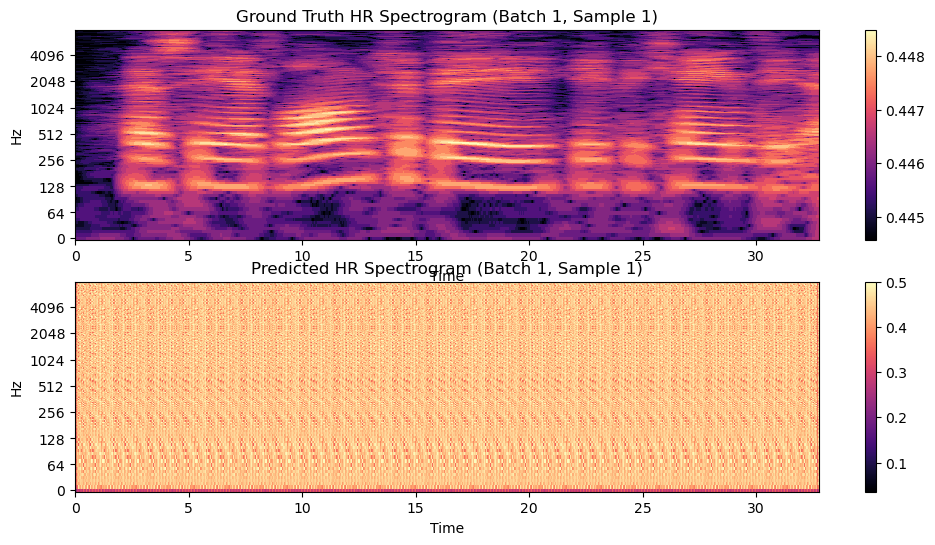

In [76]:
import matplotlib.pyplot as plt
import librosa.display
import torch

# Assuming test_loader, model, and device are already defined

# Number of batches to plot
num_batches_to_plot = 5

# Loop over the batches in the test loader
for i, (lr_spectrogram, hr_spectrogram) in enumerate(test_loader):
    if i >= num_batches_to_plot:
        break

    lr_spectrogram = lr_spectrogram.to(device)

    with torch.no_grad():
        predicted_hr_spectrogram = model(lr_spectrogram)

    plt.figure(figsize=(12, 6))

    # Plot Ground Truth HR (selecting the first sample in the batch)
    plt.subplot(2, 1, 1)
    plt.title(f"Ground Truth HR Spectrogram (Batch {i+1}, Sample 1)")
    librosa.display.specshow(hr_spectrogram[0].cpu().numpy().squeeze(), sr=16000, x_axis='time', y_axis='log')
    plt.colorbar()

    # Plot Predicted HR (selecting the first sample in the batch)
    plt.subplot(2, 1, 2)
    plt.title(f"Predicted HR Spectrogram (Batch {i+1}, Sample 1)")
    librosa.display.specshow(predicted_hr_spectrogram[0].cpu().numpy().squeeze(), sr=16000, x_axis='time', y_axis='log')
    plt.colorbar()

    plt.show()


In [69]:
# Saving the state_dict
torch.save(model.state_dict(), "timit_model_state_dict_from_scratch_improved.pth")

'''
# Loading the state_dict
model = GenerativeNetwork(device='cpu')
model.load_state_dict(torch.load("model_state_dict_from_scratch_improved.pth"))
model.to(device)
'''

'\n# Loading the state_dict\nmodel = GenerativeNetwork(device=\'cpu\')\nmodel.load_state_dict(torch.load("model_state_dict_from_scratch_improved.pth"))\nmodel.to(device)\n'

In [70]:
import numpy as np
import torch
from sklearn.metrics.pairwise import cosine_similarity

# Function to calculate PSNR between two spectrograms
def calculate_psnr(hr_spectrogram, predicted_hr_spectrogram):
    mse = torch.mean((hr_spectrogram - predicted_hr_spectrogram) ** 2)
    psnr = 10 * torch.log10(1 / mse)
    return psnr.item()

# Function to calculate Log-Spectral Distance (LSD)
def calculate_lsd(hr_spectrogram, predicted_hr_spectrogram):
    hr_spectrogram_np = hr_spectrogram.cpu().numpy()
    predicted_hr_spectrogram_np = predicted_hr_spectrogram.cpu().numpy()
    
    diff = np.log10(np.abs(hr_spectrogram_np) + 1e-8) - np.log10(np.abs(predicted_hr_spectrogram_np) + 1e-8)
    lsd = np.mean(np.sqrt(np.mean(diff**2, axis=1)))
    return lsd

# Function to calculate Mel Cepstral Distortion (MCD)
def calculate_mcd(hr_spectrogram, predicted_hr_spectrogram):
    hr_spectrogram_np = hr_spectrogram.cpu().numpy()
    predicted_hr_spectrogram_np = predicted_hr_spectrogram.cpu().numpy()
    
    diff = hr_spectrogram_np - predicted_hr_spectrogram_np
    mcd = np.mean(np.sqrt(np.sum(diff**2, axis=1)))
    return mcd

# Function to calculate Cosine Similarity between two spectrograms
def calculate_cosine_similarity(hr_spectrogram, predicted_hr_spectrogram):
    hr_spectrogram_np = hr_spectrogram.cpu().numpy()
    predicted_hr_spectrogram_np = predicted_hr_spectrogram.cpu().numpy()
    
    hr_flattened = hr_spectrogram_np.flatten().reshape(1, -1)
    predicted_flattened = predicted_hr_spectrogram_np.flatten().reshape(1, -1)
    cosine_sim_value = cosine_similarity(hr_flattened, predicted_flattened)[0, 0]
    return cosine_sim_value

# Assuming hr_spectrogram and predicted_hr_spectrogram are the HR ground truth and predicted spectrograms
# Normalize the GT spectrogram to match the predicted spectrogram's range [0, 1]
hr_min = hr_spectrogram.min()
hr_max = hr_spectrogram.max()

# Normalize the GT spectrogram to the range [0, 1]
hr_spectrogram_normalized = (hr_spectrogram - hr_min) / (hr_max - hr_min)

# Calculate metrics
psnr_value = calculate_psnr(hr_spectrogram_normalized, predicted_hr_spectrogram)
lsd_value = calculate_lsd(hr_spectrogram_normalized, predicted_hr_spectrogram)
mcd_value = calculate_mcd(hr_spectrogram_normalized, predicted_hr_spectrogram)
cosine_sim_value = calculate_cosine_similarity(hr_spectrogram_normalized, predicted_hr_spectrogram)

print(f'PSNR: {psnr_value:.2f} dB')
print(f'LSD: {lsd_value:.4f}')
print(f'MCD: {mcd_value:.4f}')
print(f'Cosine Similarity: {cosine_sim_value:.4f}')


PSNR: 12.75 dB
LSD: 0.8387
MCD: 0.1883
Cosine Similarity: 0.8550


1. Training vs. Validation Loss
Training Loss: 0.0009504
Validation Loss: 0.0009507
The training and validation losses are extremely close, which suggests that your model is not overfitting. Typically, overfitting is indicated by a significantly lower training loss compared to the validation loss. However, the similar values indicate that your model generalizes well to the validation data.

2. PSNR (Peak Signal-to-Noise Ratio)
PSNR: 12.75 dB
A PSNR of 12.75 dB is relatively low, especially for tasks involving audio or image reconstruction. Higher PSNR values (e.g., above 20-30 dB) are generally considered good, indicating that the reconstructed signal is close to the ground truth. The lower PSNR suggests that the model may not be reconstructing the signal with high fidelity, but it doesn't necessarily indicate overfitting.

3. LSD (Log-Spectral Distance)
LSD: 0.8387
LSD measures the difference between the log-magnitude spectra of the ground truth and predicted signals. Lower values are better, with values closer to 0 indicating better reconstruction. An LSD of 0.8387 suggests there is room for improvement in the spectral accuracy of the model's predictions.

4. MCD (Mel-Cepstral Distortion)
MCD: 0.1883
MCD is a common metric for evaluating the similarity between two sequences of cepstral coefficients, typically used in speech processing. Lower MCD values indicate better performance. An MCD of 0.1883 is quite low, suggesting good performance in this area.

5. Cosine Similarity
Cosine Similarity: 0.8550
Cosine similarity measures the cosine of the angle between two vectors, with values closer to 1 indicating higher similarity. A cosine similarity of 0.8550 is quite good, indicating that the predicted and ground truth vectors are relatively close in direction.

Summary:
No Clear Overfitting: The close training and validation loss values suggest that your model is not overfitting.
Model Performance: The PSNR and LSD values suggest that while your model is performing reasonably, there might be room for improvement in the fidelity of the reconstructed signals.
MCD and Cosine Similarity: These metrics are strong, indicating that the model's predictions are generally in line with the ground truth, especially in terms of direction and cepstral features.
Next Steps:
Hyperparameter Tuning: Consider experimenting with different model architectures, learning rates, or regularization techniques to improve PSNR and LSD.
More Data or Augmentation: If possible, try adding more training data or using data augmentation to improve the model's ability to generalize further.
Post-Processing: Investigate any potential post-processing steps that could enhance the fidelity of the reconstructed signals, potentially improving PSNR and LSD.
While your model does not seem to be overfitting, there is still room for improving the quality of the predictions based on the metrics provided.

In [86]:
pip install torchinfo


Note: you may need to restart the kernel to use updated packages.


In [90]:
for name, layer in model.named_modules():
    print(f"Layer: {name} | Type: {layer.__class__.__name__}")

Layer:  | Type: GenerativeNetwork
Layer: vit | Type: ViTModel
Layer: vit.embeddings | Type: ViTEmbeddings
Layer: vit.embeddings.patch_embeddings | Type: ViTPatchEmbeddings
Layer: vit.embeddings.patch_embeddings.projection | Type: Conv2d
Layer: vit.embeddings.dropout | Type: Dropout
Layer: vit.encoder | Type: ViTEncoder
Layer: vit.encoder.layer | Type: ModuleList
Layer: vit.encoder.layer.0 | Type: ViTLayer
Layer: vit.encoder.layer.0.attention | Type: ViTSdpaAttention
Layer: vit.encoder.layer.0.attention.attention | Type: ViTSdpaSelfAttention
Layer: vit.encoder.layer.0.attention.attention.query | Type: Linear
Layer: vit.encoder.layer.0.attention.attention.key | Type: Linear
Layer: vit.encoder.layer.0.attention.attention.value | Type: Linear
Layer: vit.encoder.layer.0.attention.attention.dropout | Type: Dropout
Layer: vit.encoder.layer.0.attention.output | Type: ViTSelfOutput
Layer: vit.encoder.layer.0.attention.output.dense | Type: Linear
Layer: vit.encoder.layer.0.attention.output.dropo